In [1]:
import pandas as pd
import matplotlib.pyplot as plt
sp_read = pd.read_csv('../data/SP.csv')
sp = sp_read.loc[pd.to_datetime(sp_read['date'].astype(str)) >= pd.Timestamp('2010-01-01')].copy()

In [37]:
# Cell 2 – compute daily trade counts and volume
sp['date_time'] = pd.to_datetime(sp['date'].astype(str) + ' ' + sp['time'].astype(str))
sp['date'] = sp['date_time'].dt.normalize()

daily_stats = (
    sp.groupby('date')
      .agg(trade_count=('date_time', 'count'), total_volume=('volume', 'sum'))
      .sort_index()
)
daily_stats.head()

,trade_count,total_volume
date,,
2010-01-03,262,387
2010-01-04,2510,2354
2010-01-05,2449,2109
2010-01-06,2218,1655
2010-01-07,2796,2391


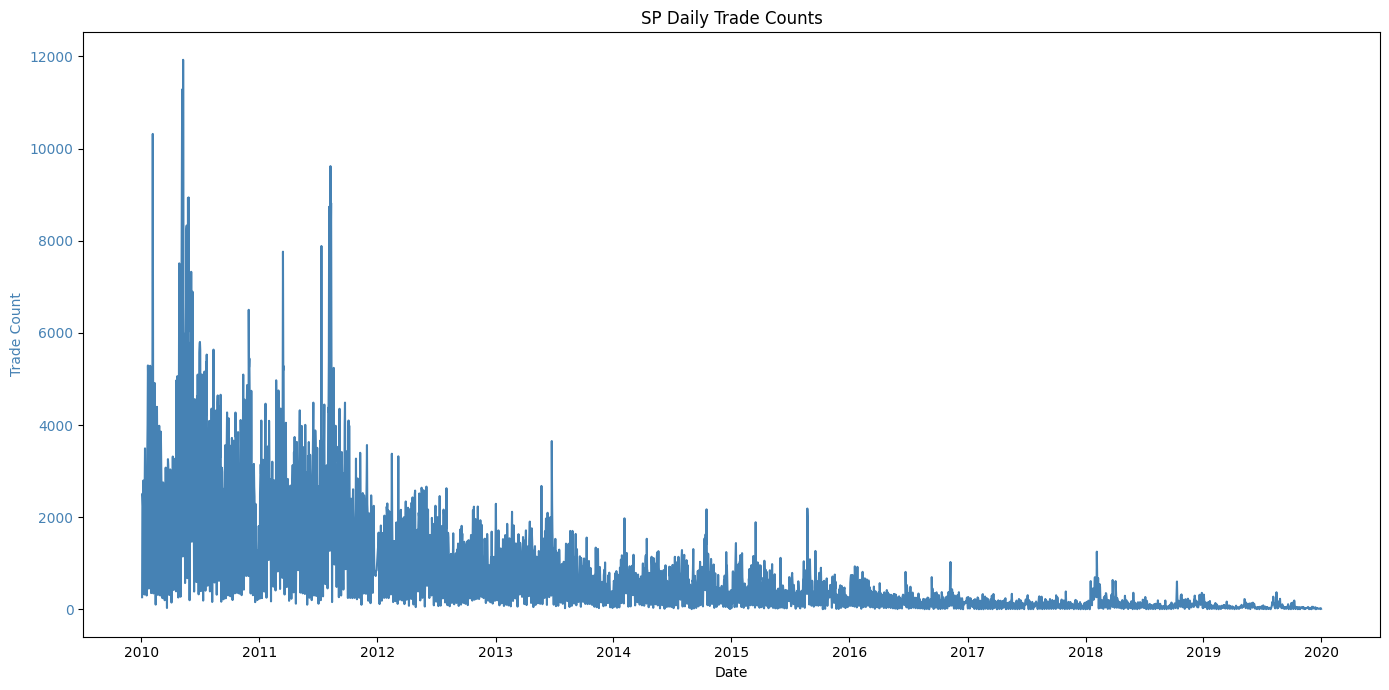

In [38]:
# Cell 3 – chart both series
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(daily_stats.index, daily_stats['trade_count'], color='steelblue', label='Daily Trade Count')
ax.set_ylabel('Trade Count', color='steelblue')
ax.tick_params(axis='y', labelcolor='steelblue')



ax.set_title('SP Daily Trade Counts')
ax.set_xlabel('Date')

lines, labels = ax.get_legend_handles_labels()

fig.tight_layout()
plt.show()

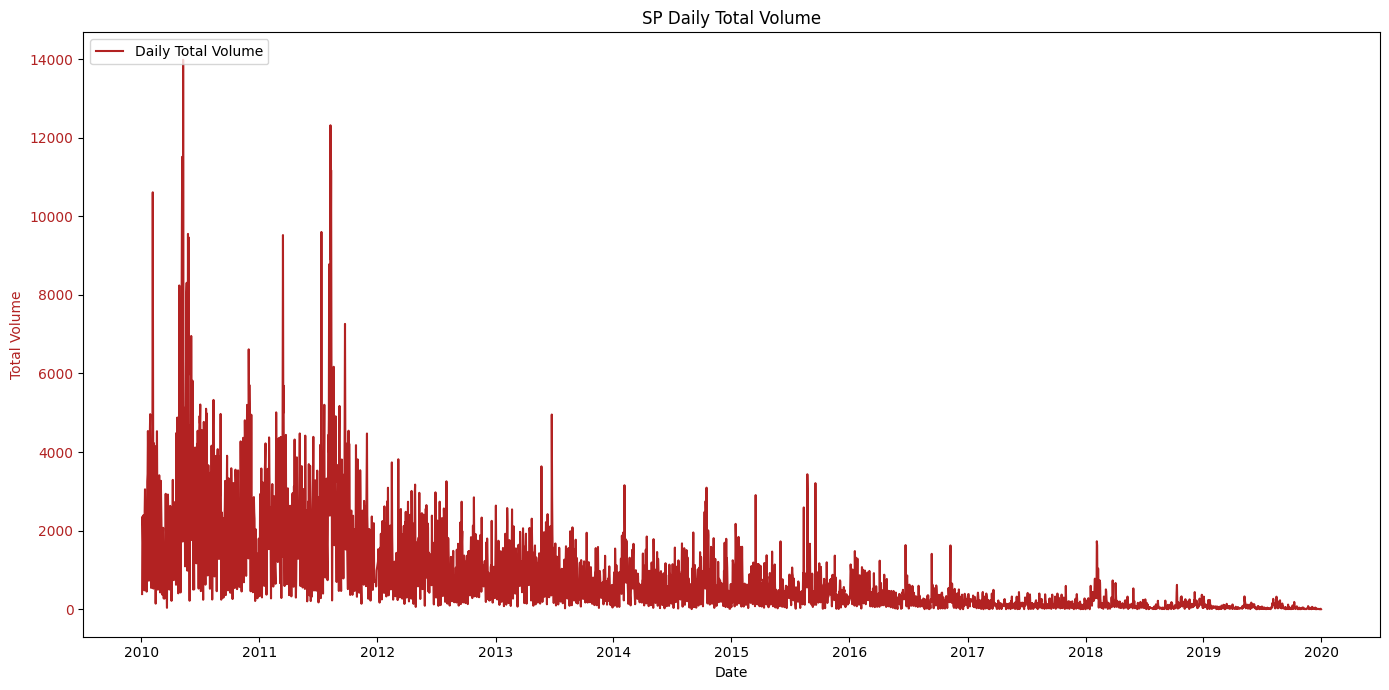

In [4]:
# Cell 3 – chart both series
fig, ax = plt.subplots(figsize=(14, 7))


ax.plot(daily_stats.index, daily_stats['total_volume'], color='firebrick', label='Daily Total Volume')
ax.set_ylabel('Total Volume', color='firebrick')
ax.tick_params(axis='y', labelcolor='firebrick')

ax.set_title('SP Daily Total Volume')
ax.set_xlabel('Date')

lines, labels = ax.get_legend_handles_labels()

ax.legend(lines, labels, loc='upper left')

fig.tight_layout()
plt.show()

In [5]:
# Convert time column to string format first, then combine
sp['date_time'] = pd.to_datetime(sp['date'].astype(str) + ' ' + sp['time'].astype(str))
sp_processed = sp[['date_time', 'price', 'volume']].copy()
sp_processed.columns = ['date_time', 'price', 'volume']

In [6]:
from mlfinlab.data_structures import standard_data_structures
dollar_bars = standard_data_structures.get_dollar_bars(
    sp_processed, threshold=1000000, batch_size=100000, verbose=False
)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=dollar_bars[:].index,
                open=dollar_bars['open'],
                high=dollar_bars['high'],
                low=dollar_bars['low'],
                close=dollar_bars['close'])])
fig.update_layout(title='Dollar Bars - Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()


<frozen mlfinlab.util.fast_ewma>:17: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [30]:
def get_daily_vol(close, span=100, lookback=pd.Timedelta("1D")):
    if isinstance(close, pd.DataFrame):
        close = close['close']
    close = close.sort_index()
    if not isinstance(close.index, pd.DatetimeIndex):
        raise ValueError("Input series must have a DatetimeIndex.")

    idx = close.index
    prev_locs = idx.get_indexer(idx - lookback, method='pad')
    valid = prev_locs >= 0
    rets = close.iloc[valid].values / close.iloc[prev_locs[valid]].values - 1.0
    rets = pd.Series(rets, index=idx[valid])
    return rets.ewm(span=span).std()*2

In [31]:
# From GPT-5
def get_t_events(price, h):
    price = price.sort_index()
    if isinstance(h, pd.Series):
        h = h.reindex(price.index)
#    diff = price.diff().dropna()
    diff = price.pct_change().dropna()
    t_events, s_pos, s_neg = [], 0.0, 0.0

    for t in diff.index:
        s_pos = max(0.0, s_pos + diff.loc[t])
        s_neg = min(0.0, s_neg + diff.loc[t])
        threshold = h.loc[t] if isinstance(h, pd.Series) else h
        if pd.isna(threshold):
            continue
        if s_neg < -threshold:
            s_neg = 0.0
            t_events.append(t)
        elif s_pos > threshold:
            s_pos = 0.0
            t_events.append(t)
    return pd.DatetimeIndex(t_events)

In [32]:
if not isinstance(dollar_bars.index, pd.DatetimeIndex):
    if 'date_time' in dollar_bars.columns:
        dollar_bars['date_time'] = pd.to_datetime(dollar_bars['date_time'])
        dollar_bars = dollar_bars.set_index('date_time')
    else:
        dollar_bars.index = pd.to_datetime(dollar_bars.index)
dollar_bars = dollar_bars.sort_index()

dv_dollar = get_daily_vol(dollar_bars['close'], span=100)
devents = get_t_events(dollar_bars['close'], dv_dollar)

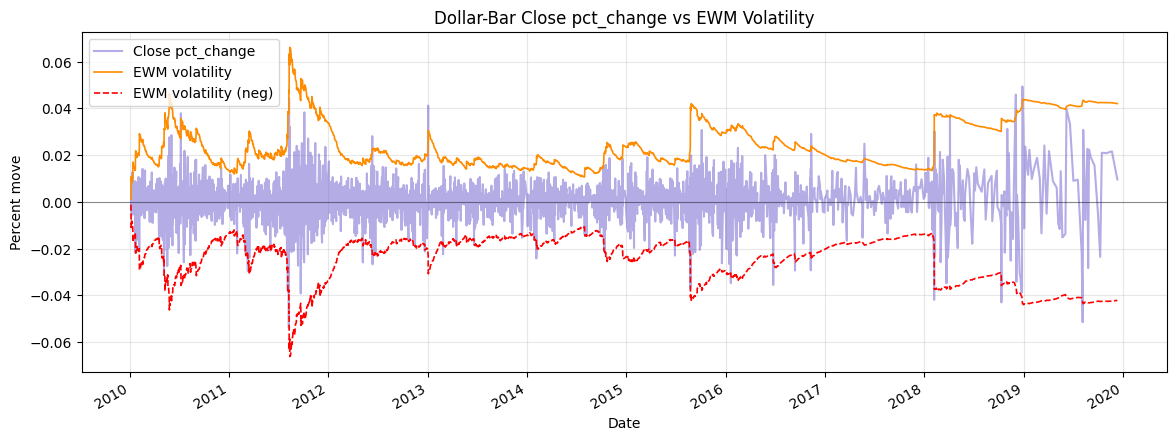

In [33]:
aligned = pd.concat(
    {
        'ewm_vol': dv_dollar,
        'ewm_vol_neg': dv_dollar*-1,
        'pct_change': dollar_bars['close'].pct_change()
    },
    axis=1
).dropna()

fig, ax = plt.subplots(figsize=(14, 5))
aligned['pct_change'].plot(ax=ax, color='slateblue', alpha=0.5, label='Close pct_change')
aligned['ewm_vol'].plot(ax=ax, color='darkorange', linewidth=1.2, label='EWM volatility')
aligned['ewm_vol_neg'].plot(ax=ax, color='red', linewidth=1.2, label='EWM volatility (neg)', linestyle='--')

ax.axhline(0, color='black', linewidth=0.8, alpha=0.4)
ax.set_title('Dollar-Bar Close pct_change vs EWM Volatility')
ax.set_xlabel('Date')
ax.set_ylabel('Percent move')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
plt.show()

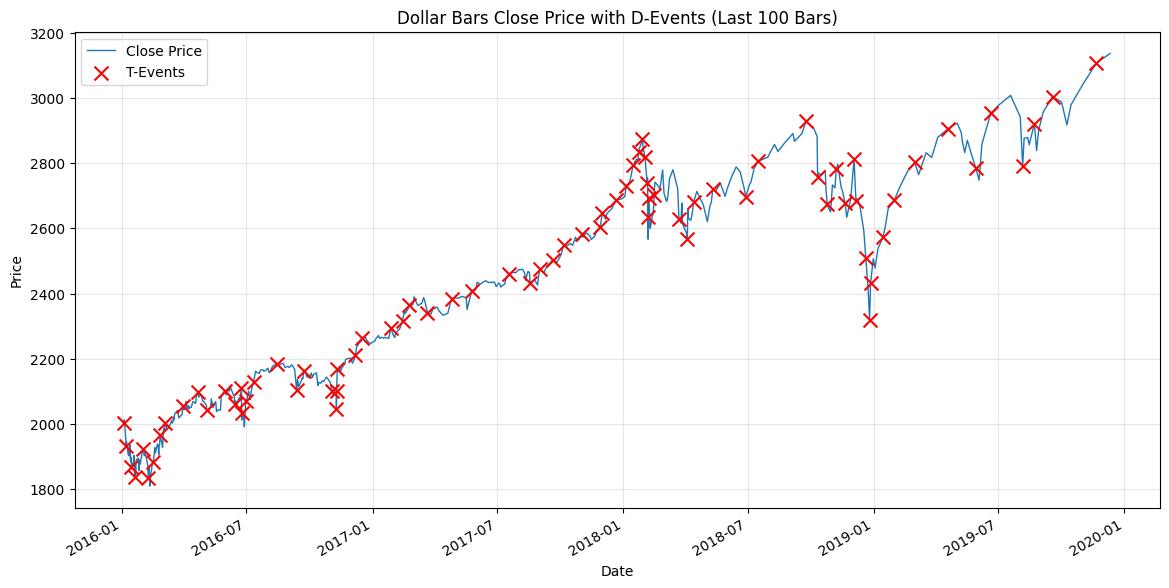

In [34]:
# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot last 100 close prices
dollar_bars['close'][-500:].plot(ax=ax, label='Close Price', linewidth=1)

# Overlay devents with 'x' markers (only those in the last 500 bars)
if len(devents) > 0:
    # Filter devents to only those in the last 500 bars
    last_x_dates = dollar_bars[-500:].index
    devents_filtered = devents[devents.isin(last_x_dates)]
    
    if len(devents_filtered) > 0:
        # Get close prices at tevent dates
        devent_prices = dollar_bars.loc[devents_filtered, 'close']
        ax.scatter(devents_filtered, devent_prices, color='red', marker='x', s=100, 
                   label='T-Events', zorder=5)

plt.title('Dollar Bars Close Price with D-Events (Last 100 Bars)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()